In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
import time
sns.set()

In [2]:
def reducedimension(
    input_, dimension = 2, learning_rate = 0.01, hidden_layer = 256, epoch = 20
):

    input_size = input_.shape[1]
    X = tf.placeholder('float', [None, input_size])
    first_layer_encoder = tf.layers.dense(
        X, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_encoder = tf.layers.dense(
        first_layer_encoder, dimension, activation = tf.nn.sigmoid
    )
    first_layer_decoder = tf.layers.dense(
        second_layer_encoder, hidden_layer, activation = tf.nn.sigmoid
    )
    second_layer_decoder = tf.layers.dense(
        first_layer_decoder, input_size, activation = tf.nn.sigmoid
    )
    cost = tf.reduce_mean(tf.square(X - second_layer_decoder))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    for i in range(epoch):
        last_time = time.time()
        _, loss = sess.run([optimizer, cost], feed_dict = {X: input_})
        if (i + 1) % 10 == 0:
            print(
                'epoch:', i + 1, 'loss:', loss, 'time:', time.time() - last_time
            )

    vectors = sess.run(second_layer_encoder, feed_dict = {X: input_})
    tf.reset_default_graph()
    return vectors

In [3]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [4]:
df = pd.read_csv('../dataset/GOOG-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [5]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.123285,0.093923,0.124080,0.112708,0.112708,0.280549
1,0.083119,0.054180,0.108808,0.090008,0.090008,0.296007
2,0.022265,0.055572,0.079545,0.089628,0.089628,0.337838
3,0.109713,0.105948,0.155523,0.160459,0.160459,0.217824
4,0.142359,0.141421,0.181922,0.188066,0.188066,0.166670


You can try to reduce dimensions if you more features like sentiment value, sentiment spike and etc

In [6]:
thought_vector = reducedimension(
    df_log.values,
    dimension = 16,
    learning_rate = 0.001,
    hidden_layer = 128,
    epoch = 100,
)

epoch: 10 loss: 0.10493937 time: 0.0007493495941162109
epoch: 20 loss: 0.10440111 time: 0.0006587505340576172
epoch: 30 loss: 0.10386688 time: 0.0006384849548339844
epoch: 40 loss: 0.10333668 time: 0.0006258487701416016
epoch: 50 loss: 0.1028106 time: 0.0006365776062011719
epoch: 60 loss: 0.10228868 time: 0.0006313323974609375
epoch: 70 loss: 0.10177094 time: 0.00061798095703125
epoch: 80 loss: 0.10125743 time: 0.0006356239318847656
epoch: 90 loss: 0.10074818 time: 0.0006313323974609375
epoch: 100 loss: 0.10024326 time: 0.0006988048553466797


In [7]:
thought_vector.shape

(252, 16)

In [8]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.1

In [9]:
tf.reset_default_graph()
modelnn = Model(0.001, num_layers, thought_vector.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [10]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(thought_vector[k:index], axis = 0)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.06878081410191954
epoch: 200 avg loss: 0.06767753483727575
epoch: 300 avg loss: 0.06797538126818836
epoch: 400 avg loss: 0.06548302624374629
epoch: 500 avg loss: 0.06514573697932065


In [11]:
output_predict = np.zeros((df_log.shape[0] + 1, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((1, num_layers * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                thought_vector[k : k + timestamp], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(thought_vector[upper_b:], axis = 0),
        modelnn.hidden_layer: init_value,
    },
)
init_value = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

In [12]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [13]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

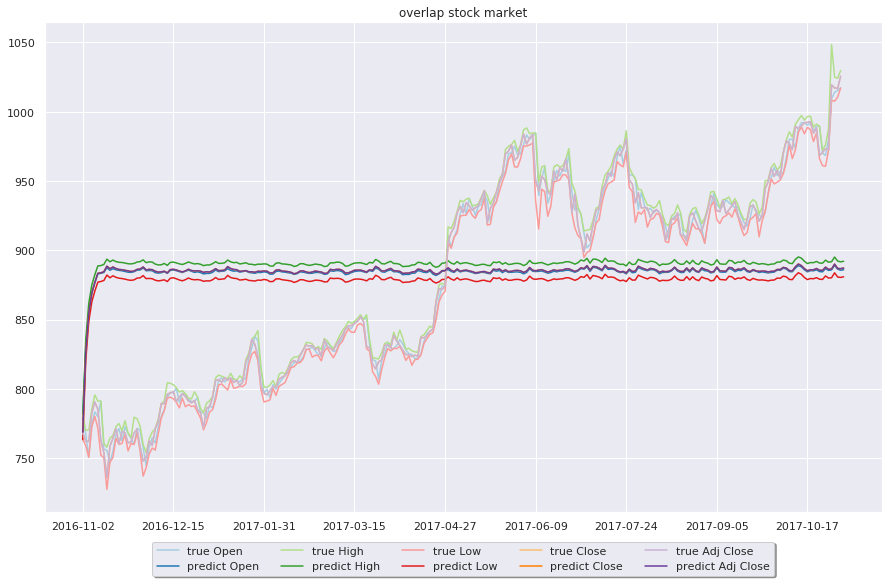

In [14]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()